In [1]:
%reset -f
import pandas as pd
import numpy as np

from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

import re, sqlite3, pickle, time, datetime, random, sys
# sys.path is a list of absolute path strings
sys.path.append('/home/d/dlr10/Documents/02_Statitics_modelling/0_FunctionsScripts')
import Loading_Data_Functions as load_fn
import FineTuning_Functions as FineTuning
import Learning_Curves_Functions as LearningCurves

pd.options.display.float_format = '{:,.3f}'.format

2023-10-30 18:02:29.674887: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-30 18:02:29.674932: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# 0. Functions 

### 0.1. Encoding functions

In [2]:
############################################################
# ENCODING CATEGORICAL VARIABLES WITH TARGET ENCODER OR NORMALISE CONTINUOUS VARIABLES
# https://towardsdatascience.com/target-encoding-and-bayesian-target-encoding-5c6a6c58ae8c
############################################################
def target_encoder_Binary(column, target, X_data):
    df = []
    for cat in X_data[column].unique():
        row = []
        row.append(len(X_data[(X_data[target]==0) & (X_data[column] == cat)]))
        row.append(len(X_data[(X_data[target]==1) & (X_data[column] == cat)]))
        df.append(row)
    df = pd.DataFrame(df, index = X_data[column].unique(), columns = ['0','1'])
    df['prob'] = df['1']/(df['1']+df['0'])
    col_encod = X_data[column].map(dict(zip(df.index, df['prob'])))
    return col_encod, df
############################################################
def Normalise_n_encode_train_set(X_data, feat_list, data_types):
    encoder = []
    X_data_norm_2 = pd.DataFrame()
    for feat in feat_list:
        if data_types[feat] == 'Continuous':
            X_data_feat = X_data[feat]
            mean        = X_data_feat.mean()
            std         = X_data_feat.std()
            X_data_norm_2[feat] = (X_data_feat - mean)/std
            encoder.append([feat, data_types[feat], [mean, std]])
        elif data_types[feat] == 'Categorical':
            X_data_norm_2[feat],df = target_encoder_Binary(feat, 'Mortality', X_data)
            encoder.append([feat, data_types[feat], df])
        elif data_types[feat] == 'Binary':
            X_data_norm_2[feat] = X_data[feat].copy()
            encoder.append([feat, data_types[feat], ""])
    encoder =pd.DataFrame(encoder, columns = ['feature','type','parameters'])
    return X_data_norm_2,encoder
############################################################
def Normalise_n_encode_val_set(val_data, norm_encoder, feat_list, data_types):
    X_data_norm_2 = pd.DataFrame()
    for feat in feat_list:
        if data_types[feat] == 'Continuous':
            X_data_feat = val_data[feat]
            mean, std   = norm_encoder[norm_encoder['feature'] == feat].iloc[0]['parameters']
            X_data_norm_2[feat] = (X_data_feat - mean)/std

        elif data_types[feat] == 'Categorical':
            df = norm_encoder[norm_encoder['feature'] == feat].iloc[0]['parameters']
            X_data_norm_2[feat] = val_data[feat].map(dict(zip(df.index, df['prob'])))
            X_data_norm_2[feat] = X_data_norm_2[feat].fillna(0)
        elif data_types[feat] == 'Binary':
            X_data_norm_2[feat] = val_data[feat].copy()
    return X_data_norm_2
############################################################

### 0.2. Split Data Function

In [3]:
def train_valid_sets(X_train_set, X_valid_set):
    #######################################
    ### BALANCED DATA
    #######################################
    random.seed(2)
    X_0 = X_train_set[X_train_set['Mortality'] == 0]
    X_1 = X_train_set[X_train_set['Mortality'] == 1]

    list_X_0 = random.sample(range(len(X_0)),len(X_1))
    X_0_2 = X_0.iloc[list_X_0]

    X_data_bal = pd.concat([X_1,X_0_2])
    
    #######################################
    ### SPLIT DATA
    #######################################
    
    train_set = X_data_bal
    valid_set = X_valid_set

    print('total admissions 16 18', len(X_train_set))
    print('total admissions 19 20', len(X_valid_set))
    print('X_train', len(train_set))
    print('Admissions neg (mortal - class = 0):', len(train_set[train_set['Mortality']==0]),
          'Admissions pos (recover- class = 1):', len(train_set[train_set['Mortality']==1]))
    print('X_valid', len(valid_set))
    print('Admissions neg (mortal - class = 0):', len(valid_set[valid_set['Mortality']==0]), 
          'Admissions pos (recover- class = 1):', len(valid_set[valid_set['Mortality']==1]))
    return train_set, valid_set

### 0.3. Encoding Data Function

In [4]:
def encoding_data(train_set, valid_set, feat_list, data_types):
    ############################################################
    train_set_norm, encoder = Normalise_n_encode_train_set(train_set, feat_list, data_types)
    valid_set_norm          = Normalise_n_encode_val_set(valid_set, encoder, feat_list, data_types)
    print("==========================================================================================================")
    print('----------------------------------TRAIN SET---------------------------------------------------------------')
    print("==========================================================================================================")
    display(train_set.head(4))
    display(train_set_norm.head(4))
    print("==========================================================================================================")
    print('----------------------------------VALIDATION SET----------------------------------------------------------')
    print("==========================================================================================================")
    display(valid_set.head(4))
    display(valid_set_norm.head(4))
    display(encoder)
    return train_set_norm, valid_set_norm, encoder

# 1. Load Data

In [5]:
t = time.time()
path = r'/home/d/dlr10/Documents/02_Statitics_modelling/DataSets/'

X_data_16_18 = pickle.load(open(path + 'df_first_curb_2016_18.pickle','rb'))
X_data_19_20 = pickle.load(open(path + 'df_first_curb_2019_20.pickle','rb'))


print("=================================FIRST RECORDED SAMPLE ADMISSION=================================")
print("-------------------------------------- 2016 - 2018 ----------------------------------------------")
display(X_data_16_18[0].head(3))
print("")
print("-------------------------------------- 2019 - 2020 ----------------------------------------------")
display(X_data_19_20[0].head(3))

print("Elapsed time:", time.time()-t)

=================================FIRST RECORDED SAMPLE ADMISSION=================================
-------------------------------------- 2016 - 2018 ----------------------------------------------


,admission_id,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin,Mortality
0,67812046,25.000,6,116.000,37.500,150.000,82.000,94.000,1.000,1,1,0,40,0,0,0.000,0
144,52393258,18.000,4,94.000,36.300,136.000,67.000,99.000,1.000,1,-1,0,53,2,0,0.000,0
288,62865417,28.000,5,109.000,38.200,112.000,76.000,99.000,1.000,1,1,0,47,0,1,1.000,0



-------------------------------------- 2019 - 2020 ----------------------------------------------


,admission_id,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin,Mortality
0,6361876,26.000,8,132.000,37.400,183.000,77.000,100.000,1.000,0,-1,1,57,3,1,1.000,0
144,66737446,20.000,0,65.000,37.100,142.000,76.000,99.000,0.000,0,1,8,68,0,0,0.000,0
288,34224926,18.000,4,64.000,36.600,130.000,64.000,92.000,1.000,0,-1,0,74,3,1,1.000,0


Elapsed time: 0.04978585243225098


In [9]:
print('training set')
print('CURB Low discharged', len(X_data_16_18[0][X_data_16_18[0]['Mortality'] == 0]))
print('CURB Low deceased', len(X_data_16_18[0][X_data_16_18[0]['Mortality'] == 1]))
print('')
print('CURB mid discharged', len(X_data_16_18[1][X_data_16_18[1]['Mortality'] == 0]))
print('CURB mid deceased', len(X_data_16_18[1][X_data_16_18[1]['Mortality'] == 1]))
print('')
print('CURB hig discharged', len(X_data_16_18[2][X_data_16_18[2]['Mortality'] == 0]))
print('CURB hig deceased', len(X_data_16_18[2][X_data_16_18[2]['Mortality'] == 1]))

training set
CURB Low discharged 1113
CURB Low deceased 51

CURB mid discharged 935
CURB mid deceased 111

CURB hig discharged 907
CURB hig deceased 202


In [10]:
print('validationset')
print('CURB Low discharged', len(X_data_19_20[0][X_data_19_20[0]['Mortality'] == 0]))
print('CURB Low deceased', len(X_data_19_20[0][X_data_19_20[0]['Mortality'] == 1]))

print('')
print('CURB mid discharged', len(X_data_19_20[1][X_data_19_20[1]['Mortality'] == 0]))
print('CURB mid deceased', len(X_data_19_20[1][X_data_19_20[1]['Mortality'] == 1]))
print('')
print('CURB hig discharged', len(X_data_19_20[2][X_data_19_20[2]['Mortality'] == 0]))
print('CURB hig deceased', len(X_data_19_20[2][X_data_19_20[2]['Mortality'] == 1]))

validationset
CURB Low discharged 380
CURB Low deceased 31

CURB mid discharged 331
CURB mid deceased 61

CURB hig discharged 211
CURB hig deceased 54


In [6]:
feat_list = X_data_16_18[0].columns.tolist()
feat_list = feat_list[1:-1]
print(feat_list)
print("Number of features:",len(feat_list))

['rr', 'ews', 'heart_rate', 'temperature', 'sbp', 'dbp', 'Oxygen_Saturation', 'Assisted_O2', 'Confusion', 'sex', 'ethnicity', 'age_at_admin', 'Comorb_score', 'Spcfc_Comorb', 'had_Prev_admin']
Number of features: 15


In [7]:
# Loading the CSV with types
data_types = pd.read_csv('/home/d/dlr10/Documents/02_Statitics_modelling/2_Statistics/csv_Type_variables.csv')
# Dictionary of features and types
data_types = data_types.set_index('Variable').to_dict()['Type']

In [8]:
############################################################
# Results DataFrame Creation
############################################################

# Modelling parameters SVM Classfier

In [9]:
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

t = time.time()
# define model
model = LogisticRegression(solver = 'saga', max_iter =10000)
# define grid
weights = [{1:1}, {1:2}, {1:3}, {1:4},{1:5},{1:8},{1:10}, {1:25},{1:50},{1:75},{1:99},{1:100},{1:500}]
regularisation = [None, 'l2', 'l1', 'elasticnet']
solvers = ['lbfgs', 'saga', 'liblinear']
#weights = [1]
param_grid = dict(class_weight=weights, penalty = regularisation)#, solver = solvers)
scoring = {"AUC": "roc_auc", "Recall": "recall"}
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring=scoring, refit = "Recall")

# 2. Modelling SVM classifier

In [10]:
def train_grid_XGB_model(train_set, valid_set, X_train_set, X_valid_set, grid, feat_list):
    df_results_train = pd.DataFrame()
    df_results       = pd.DataFrame()
    dict_fpr_tpr     = {}
    X_train = np.array(train_set[feat_list]); Y_train = np.array(X_train_set['Mortality'])
    X_valid = np.array(valid_set[feat_list]); Y_valid = np.array(X_valid_set['Mortality'])
    #################################################################
    #################################################################
    # TRAINING THE MODEL
    #################################################################
    t = time.time()
    # execute the grid search
    grid_result = grid.fit(X_train, Y_train)
    # report the best configuration
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    # report all configurations
    auc_means = grid_result.cv_results_['mean_test_AUC']
    rcl_means = grid_result.cv_results_['mean_test_Recall']
    params    = grid_result.cv_results_['params']
    print("AUC    (call)")
    for mean, rcl, param in zip(auc_means, rcl_means, params):
        print("%f (%f) with: %r" % (mean, rcl, param))    
    df_results_train['NoF_auc'] = auc_means
    df_results_train['NoF_rcl'] = rcl_means
    print("")
    print("time elapased training: ", time.time()-t)
    #################################################################
    #################################################################
    # results - Model Validation
    #################################################################

    y_scores  = grid.predict(X_valid)
    y_predict = FineTuning.adjusted_classes(y_scores, 0.5)
    y_proba   = grid.predict_proba(X_valid)[:,1]
    df_results, fpr_tpr = LearningCurves.results_precision_recall_cm(Y_valid, y_predict, y_proba, fig_size = None)
    plt.show()
    dict_fpr_tpr['NoF'] = fpr_tpr
    df_results = df_results.set_index(pd.Series('NoF'))
    display(df_results)
    return [df_results_train, df_results, dict_fpr_tpr]

# CURB65 Group 1

In [11]:
X_train_set = X_data_16_18[0]
X_valid_set = X_data_19_20[0]
train_set, valid_set = train_valid_sets(X_train_set, X_valid_set)
print("")
train_set_norm, valid_set_norm, _ = encoding_data(train_set, valid_set, feat_list, data_types)

total admissions 16 18 1164
total admissions 19 20 411
X_train 102
Admissions neg (mortal - class = 0): 51 Admissions pos (recover- class = 1): 51
X_valid 411
Admissions neg (mortal - class = 0): 380 Admissions pos (recover- class = 1): 31

----------------------------------TRAIN SET---------------------------------------------------------------


,admission_id,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin,Mortality
1008,55288256,26.000,5,90.000,37.500,177.000,93.000,96.000,1.000,0,1,0,86,4,0,1.000,1
3456,77389441,32.000,10,115.000,36.800,127.000,83.000,90.000,1.000,0,-1,0,60,8,1,1.000,1
10656,76701653,24.000,7,112.000,36.000,137.000,67.000,100.000,1.000,0,1,0,87,8,0,0.000,1
13248,99593683,20.000,5,97.000,38.700,171.000,104.000,86.000,1.000,1,-1,0,91,1,0,1.000,1


,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin
1008,1.171,0.529,-0.552,0.237,2.098,1.166,0.421,1.000,0,1,0.536,1.381,1.320,0,1.000
3456,2.858,0.833,0.741,-0.468,-0.115,0.429,-1.225,1.000,0,-1,0.536,-0.384,3.440,1,1.000
10656,0.608,0.636,0.586,-1.273,0.328,-0.750,1.518,1.000,0,1,0.536,1.449,3.440,0,0.000
13248,-0.517,0.529,-0.190,1.444,1.833,1.976,-2.322,1.000,1,-1,0.536,1.721,-0.270,0,1.000


----------------------------------VALIDATION SET----------------------------------------------------------


,admission_id,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin,Mortality
0,6361876,26.000,8,132.000,37.400,183.000,77.000,100.000,1.000,0,-1,1,57,3,1,1.000,0
144,66737446,20.000,0,65.000,37.100,142.000,76.000,99.000,0.000,0,1,8,68,0,0,0.000,0
288,34224926,18.000,4,64.000,36.600,130.000,64.000,92.000,1.000,0,-1,0,74,3,1,1.000,0
432,526683,20.000,3,95.000,36.700,127.000,89.000,97.000,1.000,0,1,0,48,0,0,1.000,0


,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin
0,1.171,0.500,1.621,0.136,2.364,-0.013,1.518,1.000,0,-1,0.500,-0.588,0.790,1,1.000
144,-0.517,0.750,-1.846,-0.166,0.549,-0.087,1.244,0.000,0,1,0.000,0.159,-0.800,0,0.000
288,-1.080,0.600,-1.897,-0.669,0.018,-0.971,-0.676,1.000,0,-1,0.536,0.566,0.790,1,1.000
432,-0.517,0.286,-0.293,-0.568,-0.115,0.871,0.695,1.000,0,1,0.536,-1.199,-0.800,0,1.000


,feature,type,parameters
0,rr,Continuous,"[21.83823529411765, 3.5551954484615598]"
1,ews,Categorical,0 1 prob 5 8 9 0.529 10 1 5 0.833 7...
2,heart_rate,Continuous,"[100.67156862745098, 19.32736416161908]"
3,temperature,Continuous,"[37.264705882352935, 0.9937076346357473]"
4,sbp,Continuous,"[129.58823529411765, 22.597359409907263]"
5,dbp,Continuous,"[77.17647058823529, 13.573716422517762]"
6,Oxygen_Saturation,Continuous,"[94.4656862745098, 3.6453278139145255]"
7,Assisted_O2,Binary,
8,Confusion,Binary,
9,sex,Binary,


############### Results without encoding ##############


/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
390 fits failed out of a total of 780.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
195 fits failed with the following error:
Traceback (most recent call last):
  File "/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/

Best: 0.986667 using {'class_weight': {1: 500}, 'penalty': 'l2'}
AUC    (call)
nan (nan) with: {'class_weight': {1: 1}, 'penalty': None}
0.620242 (0.629091) with: {'class_weight': {1: 1}, 'penalty': 'l2'}
0.613333 (0.635152) with: {'class_weight': {1: 1}, 'penalty': 'l1'}
nan (nan) with: {'class_weight': {1: 1}, 'penalty': 'elasticnet'}
nan (nan) with: {'class_weight': {1: 2}, 'penalty': None}
0.617879 (0.759394) with: {'class_weight': {1: 2}, 'penalty': 'l2'}
0.618788 (0.778788) with: {'class_weight': {1: 2}, 'penalty': 'l1'}
nan (nan) with: {'class_weight': {1: 2}, 'penalty': 'elasticnet'}
nan (nan) with: {'class_weight': {1: 3}, 'penalty': None}
0.621273 (0.831515) with: {'class_weight': {1: 3}, 'penalty': 'l2'}
0.615091 (0.831515) with: {'class_weight': {1: 3}, 'penalty': 'l1'}
nan (nan) with: {'class_weight': {1: 3}, 'penalty': 'elasticnet'}
nan (nan) with: {'class_weight': {1: 4}, 'penalty': None}
0.621030 (0.856970) with: {'class_weight': {1: 4}, 'penalty': 'l2'}
0.616121 (0.869

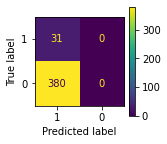

,Precision,Recall,F1_Score,Accuracy,AUC,brier,AUC_IC
NoF,0.075,1.000,0.140,0.075,0.500,0.925,"[0.5, 0.5]"


In [12]:
print("############### Results without encoding ##############")
results1     = train_grid_XGB_model(train_set, valid_set, train_set, valid_set, grid, feat_list)

############### Results encoded data ##############


/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
390 fits failed out of a total of 780.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
195 fits failed with the following error:
Traceback (most recent call last):
  File "/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/

Best: 0.986667 using {'class_weight': {1: 500}, 'penalty': 'l2'}
AUC    (call)
nan (nan) with: {'class_weight': {1: 1}, 'penalty': None}
0.643758 (0.609697) with: {'class_weight': {1: 1}, 'penalty': 'l2'}
0.624242 (0.603030) with: {'class_weight': {1: 1}, 'penalty': 'l1'}
nan (nan) with: {'class_weight': {1: 1}, 'penalty': 'elasticnet'}
nan (nan) with: {'class_weight': {1: 2}, 'penalty': None}
0.660970 (0.804848) with: {'class_weight': {1: 2}, 'penalty': 'l2'}
0.658606 (0.791515) with: {'class_weight': {1: 2}, 'penalty': 'l1'}
nan (nan) with: {'class_weight': {1: 2}, 'penalty': 'elasticnet'}
nan (nan) with: {'class_weight': {1: 3}, 'penalty': None}
0.667818 (0.823636) with: {'class_weight': {1: 3}, 'penalty': 'l2'}
0.664788 (0.850303) with: {'class_weight': {1: 3}, 'penalty': 'l1'}
nan (nan) with: {'class_weight': {1: 3}, 'penalty': 'elasticnet'}
nan (nan) with: {'class_weight': {1: 4}, 'penalty': None}
0.670545 (0.889091) with: {'class_weight': {1: 4}, 'penalty': 'l2'}
0.664242 (0.901

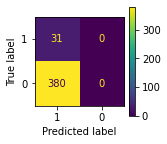

,Precision,Recall,F1_Score,Accuracy,AUC,brier,AUC_IC
NoF,0.075,1.000,0.140,0.075,0.507,0.925,"[0.5, 0.512]"


In [13]:
print("############### Results encoded data ##############")
results1_enc = train_grid_XGB_model(train_set_norm, valid_set_norm, train_set, valid_set, grid, feat_list)

# CURB65 Group 2

In [14]:
X_train_set = X_data_16_18[1]
X_valid_set = X_data_19_20[1]
train_set, valid_set = train_valid_sets(X_train_set, X_valid_set)
print("")
train_set_norm, valid_set_norm, _ = encoding_data(train_set, valid_set, feat_list, data_types)

total admissions 16 18 1046
total admissions 19 20 392
X_train 222
Admissions neg (mortal - class = 0): 111 Admissions pos (recover- class = 1): 111
X_valid 392
Admissions neg (mortal - class = 0): 331 Admissions pos (recover- class = 1): 61

----------------------------------TRAIN SET---------------------------------------------------------------


,admission_id,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin,Mortality
288,88574915,20.000,0,78.000,36.500,136.000,72.000,96.000,1.000,1,-1,0,79,7,1,1.000,1
720,18209965,20.000,0,87.000,36.900,115.000,76.000,96.000,1.000,1,-1,0,85,1,0,1.000,1
864,79826616,24.000,4,79.000,36.200,111.000,57.000,96.000,1.000,0,-1,0,79,5,0,1.000,1
1584,85889623,16.000,1,50.000,36.600,155.000,97.000,96.000,1.000,1,1,0,93,2,1,1.000,1


,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin
288,-0.470,0.529,-0.751,-0.539,0.498,0.106,0.455,1.000,1,-1,0.503,0.029,2.682,1,1.000
720,-0.470,0.529,-0.278,-0.121,-0.420,0.373,0.455,1.000,1,-1,0.503,0.675,-0.525,0,1.000
864,0.397,0.625,-0.698,-0.854,-0.595,-0.895,0.455,1.000,0,-1,0.503,0.029,1.613,0,1.000
1584,-1.337,0.333,-2.222,-0.435,1.329,1.775,0.455,1.000,1,1,0.503,1.537,0.010,1,1.000


----------------------------------VALIDATION SET----------------------------------------------------------


,admission_id,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin,Mortality
0,81895617,28.000,6,72.000,37.800,161.000,76.000,93.000,0.000,1,-1,8,93,0,1,0.000,1
144,27214872,24.000,4,73.000,37.200,124.000,64.000,98.000,0.000,1,1,0,73,3,1,1.000,0
288,52483090,18.000,4,110.000,38.400,156.000,92.000,96.000,1.000,0,-1,1,67,8,1,1.000,1
432,50639294,18.000,0,57.000,36.300,135.000,106.000,96.000,0.000,0,-1,0,84,2,1,0.000,0


,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin
0,1.263,0.438,-1.066,0.822,1.591,0.373,-0.266,0.000,1,-1,0.600,1.537,-1.059,1,0.000
144,0.397,0.625,-1.013,0.194,-0.026,-0.428,0.936,0.000,1,1,0.503,-0.617,0.544,1,1.000
288,-0.903,0.625,0.931,1.450,1.373,1.441,0.455,1.000,0,-1,1.000,-1.263,3.216,1,1.000
432,-0.903,0.529,-1.854,-0.749,0.454,2.375,0.455,0.000,0,-1,0.503,0.567,0.010,1,0.000


,feature,type,parameters
0,rr,Continuous,"[22.16891891891892, 4.615248943218096]"
1,ews,Categorical,0 1 prob 0 8 9 0.529 4 9 15 0...
2,heart_rate,Continuous,"[92.28153153153153, 19.02560245498206]"
3,temperature,Continuous,"[37.015090090090084, 0.9547853948495921]"
4,sbp,Continuous,"[124.6036036036036, 22.87523875375411]"
5,dbp,Continuous,"[70.41216216216216, 14.981442089084984]"
6,Oxygen_Saturation,Continuous,"[94.10585585585585, 4.161209789382788]"
7,Assisted_O2,Binary,
8,Confusion,Binary,
9,sex,Binary,


############### Results without encoding ##############


/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
390 fits failed out of a total of 780.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
195 fits failed with the following error:
Traceback (most recent call last):
  File "/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/

Best: 1.000000 using {'class_weight': {1: 500}, 'penalty': 'l1'}
AUC    (call)
nan (nan) with: {'class_weight': {1: 1}, 'penalty': None}
0.733938 (0.676416) with: {'class_weight': {1: 1}, 'penalty': 'l2'}
0.735699 (0.670619) with: {'class_weight': {1: 1}, 'penalty': 'l1'}
nan (nan) with: {'class_weight': {1: 1}, 'penalty': 'elasticnet'}
nan (nan) with: {'class_weight': {1: 2}, 'penalty': None}
0.733154 (0.838076) with: {'class_weight': {1: 2}, 'penalty': 'l2'}
0.732770 (0.844137) with: {'class_weight': {1: 2}, 'penalty': 'l1'}
nan (nan) with: {'class_weight': {1: 2}, 'penalty': 'elasticnet'}
nan (nan) with: {'class_weight': {1: 3}, 'penalty': None}
0.730213 (0.901054) with: {'class_weight': {1: 3}, 'penalty': 'l2'}
0.731824 (0.910013) with: {'class_weight': {1: 3}, 'penalty': 'l1'}
nan (nan) with: {'class_weight': {1: 3}, 'penalty': 'elasticnet'}
nan (nan) with: {'class_weight': {1: 4}, 'penalty': None}
0.729806 (0.940053) with: {'class_weight': {1: 4}, 'penalty': 'l2'}
0.730782 (0.948

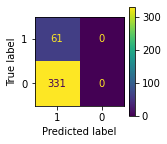

,Precision,Recall,F1_Score,Accuracy,AUC,brier,AUC_IC
NoF,0.156,1.000,0.269,0.156,0.500,0.844,"[0.5, 0.5]"


In [15]:
print("############### Results without encoding ##############")
results2     = train_grid_XGB_model(train_set, valid_set, train_set, valid_set, grid, feat_list)

############### Results encoded data ##############


/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
390 fits failed out of a total of 780.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
195 fits failed with the following error:
Traceback (most recent call last):
  File "/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/

Best: 0.993939 using {'class_weight': {1: 500}, 'penalty': 'l2'}
AUC    (call)
nan (nan) with: {'class_weight': {1: 1}, 'penalty': None}
0.747407 (0.691568) with: {'class_weight': {1: 1}, 'penalty': 'l2'}
0.753557 (0.697892) with: {'class_weight': {1: 1}, 'penalty': 'l1'}
nan (nan) with: {'class_weight': {1: 1}, 'penalty': 'elasticnet'}
nan (nan) with: {'class_weight': {1: 2}, 'penalty': None}
0.749120 (0.840975) with: {'class_weight': {1: 2}, 'penalty': 'l2'}
0.757959 (0.844005) with: {'class_weight': {1: 2}, 'penalty': 'l1'}
nan (nan) with: {'class_weight': {1: 2}, 'penalty': 'elasticnet'}
nan (nan) with: {'class_weight': {1: 3}, 'penalty': None}
0.748958 (0.906851) with: {'class_weight': {1: 3}, 'penalty': 'l2'}
0.756564 (0.912912) with: {'class_weight': {1: 3}, 'penalty': 'l1'}
nan (nan) with: {'class_weight': {1: 3}, 'penalty': 'elasticnet'}
nan (nan) with: {'class_weight': {1: 4}, 'penalty': None}
0.750024 (0.930830) with: {'class_weight': {1: 4}, 'penalty': 'l2'}
0.755060 (0.933

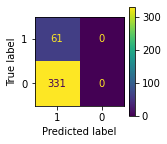

,Precision,Recall,F1_Score,Accuracy,AUC,brier,AUC_IC
NoF,0.156,1.000,0.269,0.156,0.506,0.844,"[0.5, 0.511]"


In [16]:
print("############### Results encoded data ##############")
results2_enc = train_grid_XGB_model(train_set_norm, valid_set_norm, train_set, valid_set, grid, feat_list)

# CURB65 Group 3

In [17]:
X_train_set = X_data_16_18[2]
X_valid_set = X_data_19_20[2]
train_set, valid_set = train_valid_sets(X_train_set, X_valid_set)
print("")
train_set_norm, valid_set_norm, _ = encoding_data(train_set, valid_set, feat_list, data_types)

total admissions 16 18 1109
total admissions 19 20 265
X_train 404
Admissions neg (mortal - class = 0): 202 Admissions pos (recover- class = 1): 202
X_valid 265
Admissions neg (mortal - class = 0): 211 Admissions pos (recover- class = 1): 54

----------------------------------TRAIN SET---------------------------------------------------------------


,admission_id,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin,Mortality
432,72731410,16.000,1,45.000,37.400,116.000,40.000,100.000,1.000,1,-1,0,94,4,1,0.000,1
1872,4942885,27.000,7,118.000,36.500,121.000,89.000,96.000,1.000,0,-1,0,82,1,1,1.000,1
3312,87226510,33.000,7,98.000,36.800,196.000,85.000,85.000,1.000,1,-1,0,74,3,1,0.000,1
3744,16427207,28.000,7,91.000,37.000,86.000,54.000,96.000,1.000,1,1,0,77,0,1,1.000,1


,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin
432,-1.265,0.375,-2.231,0.346,-0.168,-1.660,1.155,1.000,1,-1,0.494,1.337,1.212,1,0.000
1872,0.499,0.512,1.108,-0.634,0.049,1.191,0.316,1.000,0,-1,0.494,-0.049,-0.588,1,1.000
3312,1.462,0.512,0.193,-0.307,3.306,0.958,-1.989,1.000,1,-1,0.494,-0.973,0.612,1,0.000
3744,0.660,0.512,-0.127,-0.089,-1.471,-0.845,0.316,1.000,1,1,0.494,-0.627,-1.188,1,1.000


----------------------------------VALIDATION SET----------------------------------------------------------


,admission_id,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin,Mortality
0,65992687,19.000,2,65.000,37.000,121.000,54.000,93.000,0.000,0,-1,0,85,6,1,1.000,0
144,38145648,18.000,3,90.000,39.000,137.000,53.000,93.000,0.000,0,1,0,83,1,0,1.000,1
288,97015690,24.000,4,84.000,38.000,94.000,45.000,96.000,0.000,0,-1,0,83,0,0,1.000,0
432,70092764,22.000,8,83.000,37.400,104.000,55.000,90.000,1.000,0,-1,0,74,4,1,1.000,1


,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin
0,-0.784,0.417,-1.316,-0.089,0.049,-0.845,-0.312,0.000,0,-1,0.494,0.297,2.411,1,1.000
144,-0.944,0.512,-0.173,2.089,0.744,-0.903,-0.312,0.000,0,1,0.494,0.066,-0.588,0,1.000
288,0.018,0.561,-0.447,1.000,-1.124,-1.369,0.316,0.000,0,-1,0.494,0.066,-1.188,0,1.000
432,-0.303,0.452,-0.493,0.346,-0.689,-0.787,-0.941,1.000,0,-1,0.494,-0.973,1.212,1,1.000


,feature,type,parameters
0,rr,Continuous,"[23.887376237623762, 6.234882584357485]"
1,ews,Categorical,0 1 prob 1 20 12 0.375 7 21 22 0...
2,heart_rate,Continuous,"[93.77351485148515, 21.859466926595335]"
3,temperature,Continuous,"[37.08205445544555, 0.9179859749086493]"
4,sbp,Continuous,"[119.87747524752476, 23.02812419159461]"
5,dbp,Continuous,"[68.52722772277228, 17.18792643468642]"
6,Oxygen_Saturation,Continuous,"[94.49009900990099, 4.7722212098280306]"
7,Assisted_O2,Binary,
8,Confusion,Binary,
9,sex,Binary,


############### Results without encoding ##############


/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
390 fits failed out of a total of 780.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
195 fits failed with the following error:
Traceback (most recent call last):
  File "/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/

Best: 0.996748 using {'class_weight': {1: 75}, 'penalty': 'l1'}
AUC    (call)
nan (nan) with: {'class_weight': {1: 1}, 'penalty': None}
0.706322 (0.663415) with: {'class_weight': {1: 1}, 'penalty': 'l2'}
0.705263 (0.660122) with: {'class_weight': {1: 1}, 'penalty': 'l1'}
nan (nan) with: {'class_weight': {1: 1}, 'penalty': 'elasticnet'}
nan (nan) with: {'class_weight': {1: 2}, 'penalty': None}
0.707231 (0.874797) with: {'class_weight': {1: 2}, 'penalty': 'l2'}
0.705966 (0.879715) with: {'class_weight': {1: 2}, 'penalty': 'l1'}
nan (nan) with: {'class_weight': {1: 2}, 'penalty': 'elasticnet'}
nan (nan) with: {'class_weight': {1: 3}, 'penalty': None}
0.707038 (0.947398) with: {'class_weight': {1: 3}, 'penalty': 'l2'}
0.706467 (0.947398) with: {'class_weight': {1: 3}, 'penalty': 'l1'}
nan (nan) with: {'class_weight': {1: 3}, 'penalty': 'elasticnet'}
nan (nan) with: {'class_weight': {1: 4}, 'penalty': None}
0.707816 (0.977073) with: {'class_weight': {1: 4}, 'penalty': 'l2'}
0.706840 (0.9770

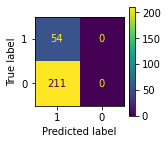

,Precision,Recall,F1_Score,Accuracy,AUC,brier,AUC_IC
NoF,0.204,1.000,0.339,0.204,0.556,0.797,"[0.52, 0.583]"


In [18]:
print("############### Results without encoding ##############")
results3     = train_grid_XGB_model(train_set, valid_set, train_set, valid_set, grid, feat_list)

############### Results encoded data ##############


/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
390 fits failed out of a total of 780.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
195 fits failed with the following error:
Traceback (most recent call last):
  File "/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/

Best: 0.998374 using {'class_weight': {1: 500}, 'penalty': 'l1'}
AUC    (call)
nan (nan) with: {'class_weight': {1: 1}, 'penalty': None}
0.721650 (0.656870) with: {'class_weight': {1: 1}, 'penalty': 'l2'}
0.721773 (0.660122) with: {'class_weight': {1: 1}, 'penalty': 'l1'}
nan (nan) with: {'class_weight': {1: 1}, 'penalty': 'elasticnet'}
nan (nan) with: {'class_weight': {1: 2}, 'penalty': None}
0.726118 (0.879756) with: {'class_weight': {1: 2}, 'penalty': 'l2'}
0.725812 (0.884756) with: {'class_weight': {1: 2}, 'penalty': 'l1'}
nan (nan) with: {'class_weight': {1: 2}, 'penalty': 'elasticnet'}
nan (nan) with: {'class_weight': {1: 3}, 'penalty': None}
0.728289 (0.945650) with: {'class_weight': {1: 3}, 'penalty': 'l2'}
0.727944 (0.940691) with: {'class_weight': {1: 3}, 'penalty': 'l1'}
nan (nan) with: {'class_weight': {1: 3}, 'penalty': 'elasticnet'}
nan (nan) with: {'class_weight': {1: 4}, 'penalty': None}
0.728574 (0.960528) with: {'class_weight': {1: 4}, 'penalty': 'l2'}
0.728468 (0.960

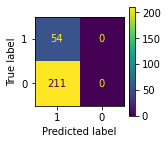

,Precision,Recall,F1_Score,Accuracy,AUC,brier,AUC_IC
NoF,0.204,1.000,0.339,0.204,0.493,0.796,"[0.47, 0.505]"


In [19]:
print("############### Results encoded data ##############")
results3_enc = train_grid_XGB_model(train_set_norm, valid_set_norm, train_set, valid_set, grid, feat_list)

# Results

# AUROC curve

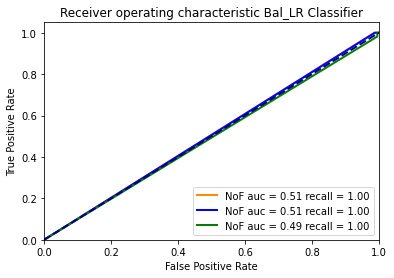

In [20]:
title = 'Bal_LR Classifier'
plt.figure()
colors = ['darkorange', 'b','g','r','c', 'm']
i = 0

results_encs =[results1_enc, results2_enc, results3_enc]

for results_enc in results_encs:

    df_results_valid = results_enc[1]
    dict_fpr_tpr     = results_enc[2]

    key = 'NoF'
    val = dict_fpr_tpr[key]
    auc = df_results_valid.loc[key,'AUC']
    rcl = df_results_valid.loc[key,'Recall']
    fpr, tpr = val

    lw = 2

    plt.plot(fpr,  tpr,  color= colors[i],  lw=lw,label= key + " auc = {:,.2f} recall = {:,.2f}".format(auc, rcl) 
        #label="ROC curve (area = %0.2f)" % metrics.roc_auc[2],
    )
    i = i + 1
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic "+ title)
plt.legend(loc="lower right")
#plt.savefig('AUROC_'+title+'.png', transparent = True, bbox_inches = "tight")
plt.show()

In [21]:
pickle.dump([results_encs], open('dict_fpr_trp_'+title+'.pickle', 'wb'))

In [22]:
for r in results_encs:
    display(r[1])

,Precision,Recall,F1_Score,Accuracy,AUC,brier,AUC_IC
NoF,0.075,1.000,0.140,0.075,0.507,0.925,"[0.5, 0.512]"


,Precision,Recall,F1_Score,Accuracy,AUC,brier,AUC_IC
NoF,0.156,1.000,0.269,0.156,0.506,0.844,"[0.5, 0.511]"


,Precision,Recall,F1_Score,Accuracy,AUC,brier,AUC_IC
NoF,0.204,1.000,0.339,0.204,0.493,0.796,"[0.47, 0.505]"
